# Computational Methods, Laboratories 9 - Task 2: OCR using DFT template matching.
### It is level up from previous task. We will use methods developed in task 1 to build fully (not really) working OCR.

In this task i will focus on Calibri font - since it is one of the most commonly used fonts, I thought it might be interesting.

Imports:

In [198]:
import numpy as np
from numpy import rot90
from numpy.fft import fft2, ifft2
from PIL import Image, ImageOps, ImageDraw, ImageFont
import os
import functools

### Our Example Photo Will Be This Sentence:

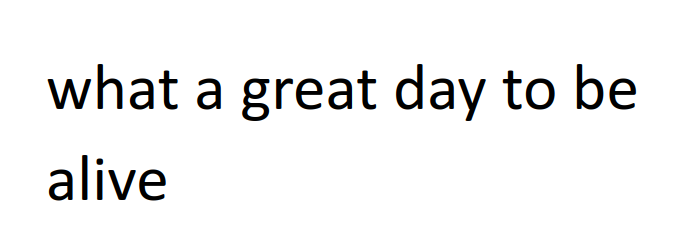

In [217]:
image = Image.open('img/example49size.png')
display(image)

Helper Functions:

In [199]:
def convert_to_rgb(image_arr):
    return np.array([[(val, val, val) for val in row] for row in image_arr])

### Loading calibri font from ttf format to images for template matching.

In [200]:

font_path = "./resources/fonts/calibri-regular.ttf"  
font_size = 64  #do not trust this font size. god knows, how does it work. 

font = ImageFont.truetype(font_path, font_size)

output_dir = "./resources/fonts/calibri_regular_letters/"
os.makedirs(output_dir, exist_ok=True)  

# Characters to create images for: a-z and special characters ? , . !
characters = list(map(chr, range(ord('a'), ord('z') + 1))) + ['?', ',', '.', '!']

for char in characters:
    image = Image.new('RGBA', (font_size, font_size), (255, 255, 255, 0))
    draw = ImageDraw.Draw(image)

    text_width, text_height = draw.textsize(char, font=font)
    
    position = ((font_size - text_width) / 2, (font_size - text_height) / 2)
    
    draw.text(position, char, font=font, fill=(0, 0, 0, 255))
    
    if char in ['?', ',', '.', '!']:
        char = {'?': 'question', ',': 'comma', '.': 'dot', '!': 'exclamation'}[char]
        
    # Save the image as a PNG file
    image.save(f"{output_dir}{char}.png")

print("Images created successfully!")


Images created successfully!


### Dictionary Where Each Key Is a Character and Its Value Is the Corresponding Filename

Although dictionaries are theoretically unordered, I have noticed that if we iterate through a dictionary, we get the output in the same order as we added the items. This is important for us because we want a specific order in terms of finding each letter. We aim to find the most common letters first and then move on to the less frequent ones. This approach provides an advantage because, in case of mix-ups, we have a higher chance of correctly identifying the letter.  
In the file `character_order` there are all characters we would like to use with corresponding filenames. Our `Alphabet` is going to be initialize in the order of this file.  
English letters by frequency can be found here: https://www3.nd.edu/~busiforc/handouts/cryptography/letterfrequencies.html

In [201]:
file_path = "./resources/character_order"

Alphabet = {}

with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            character, filename = parts
            Alphabet[character] = filename

print(Alphabet)


{'e': 'e', 'a': 'a', 'r': 'r', 'i': 'i', 'o': 'o', 't': 't', 'n': 'n', 's': 's', 'l': 'l', 'c': 'c', 'u': 'u', 'd': 'd', 'p': 'p', 'm': 'm', 'h': 'h', 'g': 'g', 'b': 'b', 'f': 'f', 'y': 'y', 'w': 'w', 'k': 'k', 'v': 'v', 'x': 'x', 'z': 'z', 'j': 'j', 'q': 'q', ',': 'comma', '.': 'dot', '!': 'exclamation', '?': 'question'}


### Function to calculate correlation. Taken from Task 1.

In [202]:
def calc_correlation(image, pattern):
    width, height = image.size
    
    correlation = ifft2( fft2(image) * fft2(rot90(pattern,2), s=(height, width)) )
    correlation = correlation.real 

    correlation /= np.abs(np.max(correlation))

    return correlation

In [203]:
COLOURS = [
    (255, 0, 0),   # Red
    (0, 255, 0),   # Green
    (0, 0, 255),   # Blue
    (255, 255, 0), # Yellow
    (0, 255, 255)  # Cyan
]

### Function for checking if there occurs match (high enough correlation). 
It also checks if there was an earlier match in this area. If we already found a good match we propably do not want to change it or double it. 

In [204]:
def check_match(correlation,certainty,x,y,character,found):
    point_corr = correlation[y,x]
    if point_corr < certainty:
        return
    for i in range(len(found)):
        b,a,_,corr = found[i]
        if abs(a-x) < 20 and abs(b-y) < 50:
            if corr + 1 < point_corr:  #ignore this if. it never goes into it. Used in earlier version for tests, discussed later. 
                found.pop(i)
                found.append((y,x,character,point_corr))
            return 
    found.append((y,x,character,point_corr))
    

### Testing
OCR for the first five letters, with five different colours! you can see for yourself how well it seems to be working!  
The function is basically an extended version of `find_pattern()` from Task 1.

In [205]:
def OCR_test(image,certainty =0.99,Alphabet = Alphabet,COLOURS = COLOURS):
    chars = []
    k = 0
    for char in Alphabet:
        if k==5:
            break
        chars.append(char)
        k+=1
    k = 0
    found = []
    char_colour_map = {chars[0]: COLOURS[0], chars[1]: COLOURS[1], chars[2]: COLOURS[2], chars[3]: COLOURS[3], chars[4]: COLOURS[4],}
    for character in Alphabet:
        if k==5:
            break
        char_name = Alphabet[character]
        letter = Image.open('resources/fonts/calibri_regular_letters/' + char_name +'.png')
        letter = ImageOps.invert(letter.convert("L"))
        correlation = calc_correlation(image,letter)
        for y in range(correlation.shape[0]):
            for x in range(correlation.shape[1]):
                check_match(correlation,certainty,x,y,character,found)
        k+=1

    image_arr = np.asarray(image)
    image_arr = convert_to_rgb(image_arr)
    result = image_arr.copy()
    selection_size = (5, -15)
    for x, y, character, _ in found:
        for dx in range(-5, selection_size[0], 1):
            for dy in range(-50, -30, 1):
                result[x + dx, y + dy] = char_colour_map[character]
                
    result = Image.fromarray(result)
    display(result)
        

### Let's Test How It Works!

Here is the character-to-colors map:

- **e** - Red
- **a** - Green
- **r** - Blue
- **i** - Yellow
- **o** - Cyan


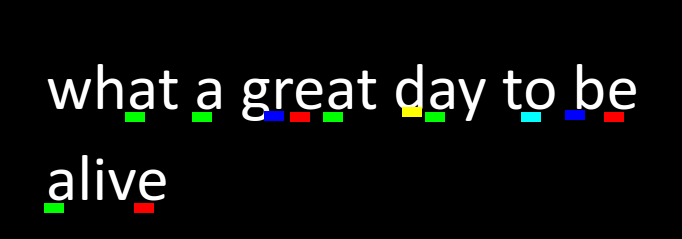

In [206]:
image = Image.open('img/example49size.png')
image = ImageOps.invert(image.convert("L"))
OCR_test(image)

### Comparator for sorting found matches. Explained later!

In [207]:
def cmp(a,b):
    epsilon = 60
    x1,y1 = a[1], a[0]
    x2,y2 = b[1], b[0]
    if y2 - y1 > epsilon:
        return -1
    if y1 - y2 > epsilon:
        return 1
    if x1 > x2:
        return 1
    return -1 

### Finally, an OCR!
params:  
image, certainty level, (ordered) Alphabet dictionary  
output:   
string

It is an upgrade of `OCR_test()` function.  
I've decided to sort the found list using a custom `cmp()` function. First, we sort it by height since we want to process the first line, then the second line, and so on. However, we do not simply compare heights and choose the higher one because small differences might occur between characters on the same line. To address this, we check if the height difference is significant enough to determine that the characters are on different lines. If the characters belong to the same line, we then compare their horizontal positions to determine which one is further to the left.

This method ensures that our characters are correctly ordered by lines and position within each line, therefore we can simply iterate through the list, and add next characters to a result string. If significant difference in height is found, we know, that it is the end of the line so we add newline character. If significant difference in horizontal coordiante is found, we know, that it is new word, so we add empty character. 

In [208]:
def OCR(image,certainty =0.97,Alphabet = Alphabet):
    found = []
    k = 0
    for character in Alphabet:
        k+=1
        char_name = Alphabet[character]
        letter = Image.open('resources/fonts/calibri_regular_letters/' + char_name +'.png')
        letter = ImageOps.invert(letter.convert("L"))
        correlation = calc_correlation(image,letter)
        for y in range(correlation.shape[0]):
            for x in range(correlation.shape[1]):
                check_match(correlation,certainty,x,y,character,found)

    result = ""
    key = functools.cmp_to_key(cmp)
    found = sorted(found,key=key)
    epsilonY = 50
    epsilonX = 40
    prev = None
    for y, x, character, _ in found:
        if prev != None and y - prev[1] > epsilonY:
            result += "\n"
        elif prev!=None and x - prev[0] > epsilonX:
            result+= " "
        prev = (x,y)

        result += character 

                
    return result

### OCR first try: 

In [209]:
image = Image.open('img/example49size.png')
image = ImageOps.invert(image.convert("L"))
print(OCR(image,0.97))

wrat a great iay to re
aive


### We Can Clearly See Some Similarities, Although We Could Argue Whether It Is a Success

Ideas for Improvement:

1. **Potential Alphabet Bias**: Characters earlier in the alphabet might have an undue advantage. In the first implementation, if a match is found at a certain position, it is never updated later. I tried modifying the `check_match()` function to consider a situation where, although a match was already found, a better match is later identified. This would ideally result in an update (this modification is currently unused, see the comment in the `check_match()` function). Interestingly, this approach worsened the results, which is why I discontinued using it.
   
2. **Order Optimization**: The chosen order might not be the most effective. To test this hypothesis, I modified the alphabet order to see if it would yield better results. Although this approach might seem like cheating, it provides insight into whether a different order improves performance.



To optimize order we introduce the `Alphabet2`: 

In [211]:
file_path = "./resources/character_order_alternative"

Alphabet2 = {}

with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            character, filename = parts
            Alphabet2[character] = filename

print(Alphabet2)


{'e': 'e', 'a': 'a', 'b': 'b', 'h': 'h', 'd': 'd', 'l': 'l', 'r': 'r', 'i': 'i', 'o': 'o', 't': 't', 'n': 'n', 's': 's', 'c': 'c', 'u': 'u', 'p': 'p', 'm': 'm', 'g': 'g', 'f': 'f', 'y': 'y', 'w': 'w', 'k': 'k', 'v': 'v', 'x': 'x', 'z': 'z', 'j': 'j', 'q': 'q', ',': 'comma', '.': 'dot', '!': 'exclamation', '?': 'question'}


In [215]:
image = Image.open('img/example49size.png')
image = ImageOps.invert(image.convert("L"))
print(OCR(image,0.97,Alphabet2))

w hat a great day to be
alve


### It Still Isn't Perfect, But It Has Definitely Improved

What is interesting is that by changing the order, we managed to improve some aspects while creating other issues. For example, there is now an additional space in "what" and the letter "i" is no longer matched because "l" is found earlier, and they are too close to each other.

### Okay, now let's try it on some longer and harder text. 
Our aim is to convert to text, photo of this beautifull Poem written by James Douglas Morrison:


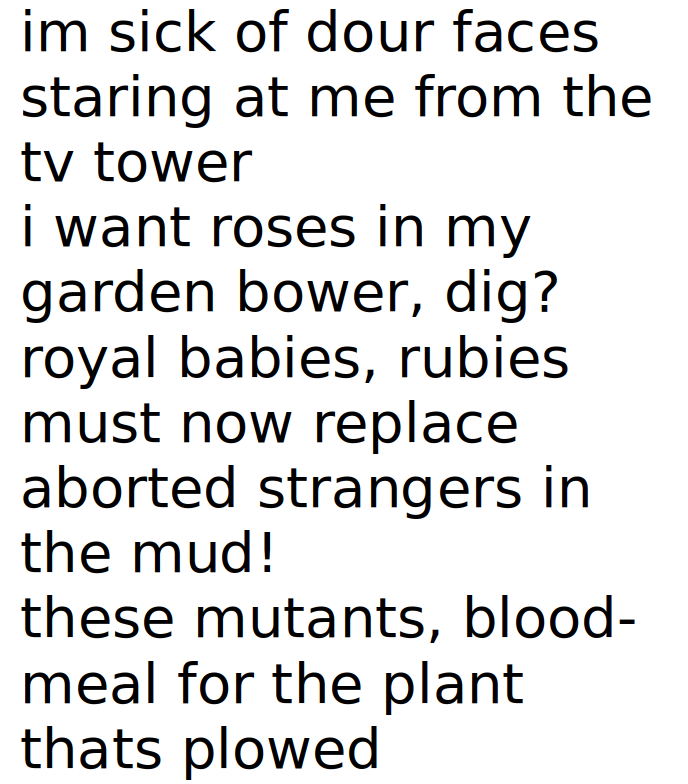

In [216]:
image = Image.open('img/poem_example.png')
display(image)

Let's try it straight away:

In [218]:
image = Image.open('img/poem_example.png')
image = ImageOps.invert(image.convert("L"))
print(OCR(image))

n s i
k of iourfa es
star t n n t
tv t wg a e fro he
o er
w a t roses n y
garie r ower igz
roya r ar es rur es
n ust ow rer a e
ar orte istra
t n gers
he u i
these n uta ts r oo i
n ea forthe r a t
thats r owe i


### If You Don't Like Poetry, You Might Not See the Difference Between the Original Photo and the Result

However, I assure you, it is not working as well as I had hoped. It seems that in more complex texts, the method is not effective at all.

Out of curiosity, let's look at the Test function and see how it handles just the first five letters.

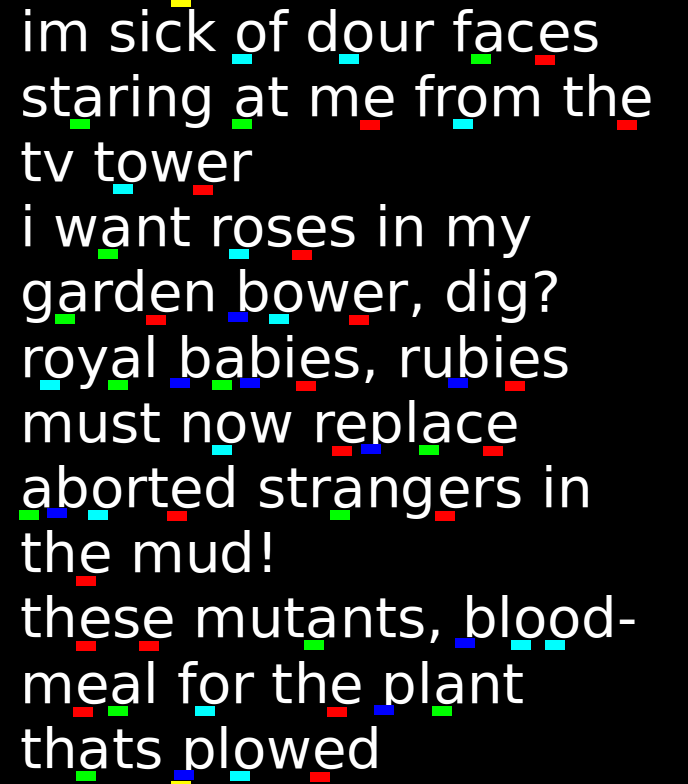

In [219]:
image = Image.open('img/poem_example.png')
image = ImageOps.invert(image.convert("L"))
OCR_test(image)

Here, it actually seems to be working quite well. I do not fully understand what is causing the catastrophic result in the main `OCR()` function.

## Conclussions